# Цель лабораторной работы
Изучить ансамбли моделей машинного обучения<cite data-cite="ue:lab6"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab6"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество модели с&nbsp;помощью одной из&nbsp;подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра. В&nbsp;зависимости от&nbsp;используемой библиотеки можно применять функцию `GridSearchCV`, использовать перебор параметров в&nbsp;цикле, или использовать другие методы.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [60]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

pd.set_option("display.width", 70)

## Предварительная подготовка данных

In [62]:

data = pd.read_csv("/Users/elizavetasukach/Desktop/MachineLearning/2019.csv")

In [63]:
data.dtypes

Overall rank                      int64
Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

In [64]:
data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Значения колонки Country or region уникальны, поэтому ее можно удалить, если заменить на цифровые значения, то значения колонки Overall rank продублируются

In [65]:
del data['Country or region']

Проверим пустые значения:


In [66]:
data.isnull().sum()

Overall rank                    0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [67]:
data.shape

(156, 8)

основные статистические характеристики:

In [68]:
data.describe()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,45.177428,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.750000,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,78.500000,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,117.250000,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,156.000000,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [69]:
X = data.drop("Score", axis=1)
y = data["Score"]
print(X.head(), "\n")
print(y.head())

Overall rank  GDP per capita  Social support  Healthy life expectancy  \
0             1           1.340           1.587                    0.986   
1             2           1.383           1.573                    0.996   
2             3           1.488           1.582                    1.028   
3             4           1.380           1.624                    1.026   
4             5           1.396           1.522                    0.999   

   Freedom to make life choices  Generosity  Perceptions of corruption  
0                         0.596       0.153                      0.393  
1                         0.592       0.252                      0.410  
2                         0.603       0.271                      0.341  
3                         0.591       0.354                      0.118  
4                         0.557       0.322                      0.298   

0    7.769
1    7.600
2    7.554
3    7.494
4    7.488
Name: Score, dtype: float64


In [70]:
print(X.shape)
print(y.shape)

(156, 7)
(156,)


Предобработаем данные, чтобы методы работали лучше:

In [71]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Overall rank,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,0.000000,1.779204e-16,-1.195625e-16,-3.188333e-16,-2.391250e-16,2.005162e-16,-3.914248e-18
std,1.003221,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00
min,-1.720983,-2.279334e+00,-4.053282e+00,-3.004986e+00,-2.748526e+00,-1.946801e+00,-1.173697e+00
25%,-0.860492,-7.614944e-01,-5.132402e-01,-7.354299e-01,-5.921083e-01,-8.014454e-01,-6.749404e-01
50%,0.000000,1.381292e-01,2.101925e-01,2.641694e-01,1.710395e-01,-7.736976e-02,-2.663845e-01
75%,0.860492,8.243362e-01,8.171048e-01,6.484713e-01,8.029119e-01,6.677699e-01,3.252258e-01
max,1.720983,1.961299e+00,1.392163e+00,1.722652e+00,1.669330e+00,4.014316e+00,3.633468e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [73]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(117, 7)
(39, 7)
(117,)
(39,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [74]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Случайный лес

Попробуем случайный лес с&nbsp;гиперпараметром $n=100$:

In [75]:
ran_100 = RandomForestRegressor(n_estimators=100)
ran_100.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [76]:
test_model(ran_100)

mean_absolute_error: 0.04623307692307656
median_absolute_error: 0.02186999999999717
r2_score: 0.9941083150048853


Видно, что данный метод даже без&nbsp;настройки гиперпараметров уже показывает очень неплохой результат.

### Градиентный бустинг

Попробуем градиентный бустинг с&nbsp;гиперпараметром $n=100$:

In [77]:
gr_100 = GradientBoostingRegressor(n_estimators=100)
gr_100.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим метрики построенной модели:

In [78]:
test_model(gr_100)

mean_absolute_error: 0.042653014430760014
median_absolute_error: 0.029796258230311068
r2_score: 0.9962759603883631


Внезапно градиентный бустинг оказался несколько хуже по&nbsp;сравнению со&nbsp;случайным лесом.

## Подбор гиперпараметра $n$

### Случайный лес

Введем список настраиваемых параметров:

In [79]:
param_range = np.arange(10, 201, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [80]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=110,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

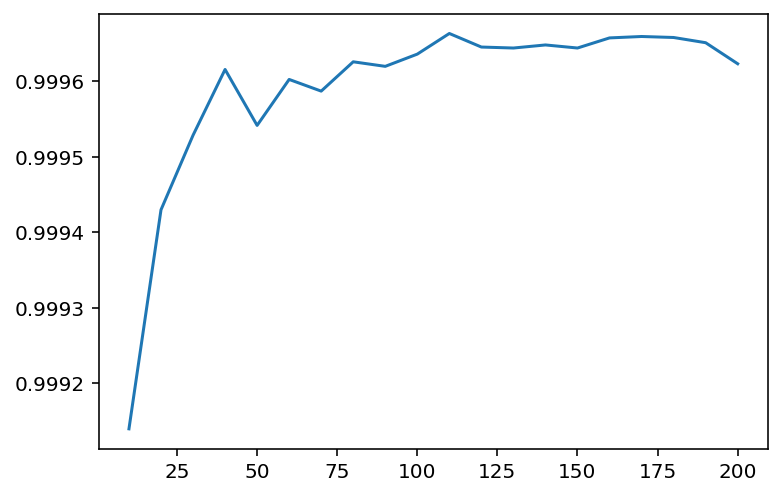

In [81]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В&nbsp;целом результат ожидаемый&nbsp;— чем больше обученных моделей, тем лучше.

На&nbsp;тестовом наборе данных картина похожа:

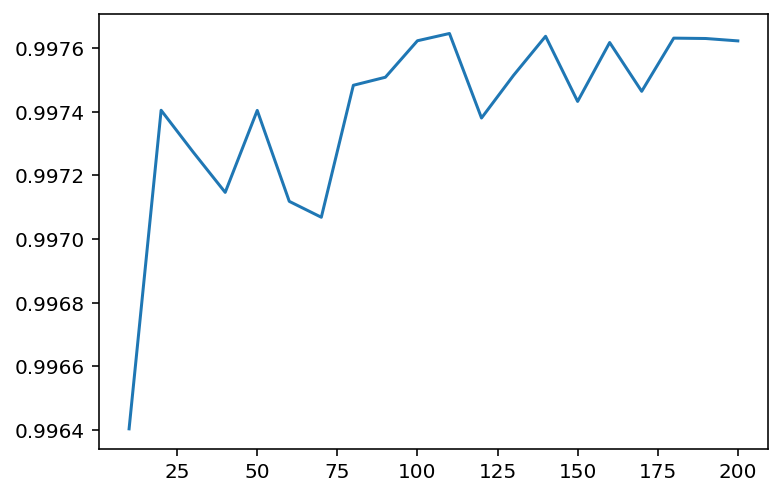

In [82]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Из-за случайнойсти график немного плавает, но конкретно в&nbsp;данном случае получился чётко выраженный пик с&nbsp;наилучшим результатом.

In [83]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.05150046620046609
median_absolute_error: 0.025118181818174712
r2_score: 0.9936828333286463


### Градиентный бустинг

Список настраиваемых параметров оставим тем же.

In [84]:
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

Запустим подбор параметра:

In [85]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

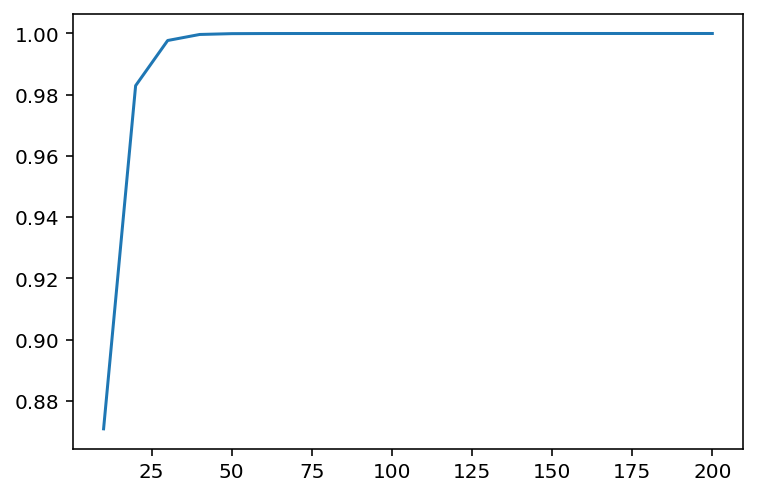

In [86]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Картина лучше, но суть та же: чем больше подмоделей, тем лучше.

На&nbsp;тестовом наборе данных картина ровно та же:

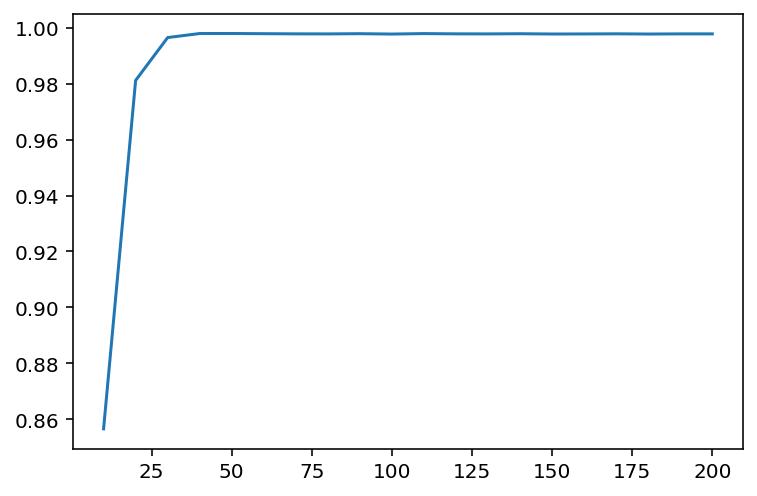

In [87]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Выходит, что чем больше подмоделей, тем лучше. Возможно, что можно использовать ещё больше моделей, но будем считать, что это выходит за&nbsp;рамки лабораторной работы.

In [88]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.044345179696531595
median_absolute_error: 0.027791779195851518
r2_score: 0.9957806303651098
